In [2]:
import pandas as pd 
import os
from config import * 
import matplotlib.pyplot as plt 
import datetime
import numpy as np 

In [3]:
trend_window = 4

def merge_rh_vol_w_barset(security):
    rh_vol = pd.read_csv('popularity_export/{}.csv'.format(security))
    rh_vol.index = pd.to_datetime(rh_vol['timestamp']).dt.date
    rh_vol.drop('timestamp',axis =1,inplace=True)
    rh_vol.drop_duplicates(inplace=True)
    bars = api.polygon.historic_agg_v2(security,1,'day',_from= rh_vol.index[0],to=datetime.date.today()).df
    bars.index = bars.index.date
    merged = bars.join(rh_vol.groupby('timestamp').max()['users_holding'])
    merged['rh_vol_pct'] = merged['users_holding']*100/merged['volume']
    merged['rh_action'] = merged['users_holding'].copy()*0
    rh_trend_up = ((merged['users_holding'] > merged['users_holding'].shift(1)).rolling(trend_window).sum() == trend_window)
    price_trend_down = ((merged['open'] < merged['open'].shift(1)).rolling(trend_window).sum() == trend_window)
    merged['rh_action'][rh_trend_up & price_trend_down] = 1
    merged['profit'] = merged['users_holding'].copy()*0
    merged['profit'][merged['rh_action'] == 1] = (merged['close'].shift(-trend_window) - merged['open'])/merged['open']
    #print('{} traded {} times, total_profit_pct: {}'.format(security,len(merged[merged['rh_action'] == 1]),merged[merged['rh_action'] == 1]['profit'].sum()))
    return merged

def normalize_merged(schema,df):
    blank_df = pd.DataFrame(0, index=schema.index, columns=list(schema))
    blank_df.update(df)
    return blank_df

# asset = merge_rh_vol_w_barset('AMD')
# print(asset[asset['rh_action'] != 0])
# print(asset[asset['rh_action'] == 1]['profit'].sum())
# fig,ax = plt.subplots()
# ax.plot(asset['close'],color ='red')
# ax2 = ax.twinx()
# ax2.plot(asset['users_holding'])
# plt.show()


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

CSCO traded, net: 0.031516674059347216, num trades: 4
PRI traded, net: 0.42952486890195446, num trades: 1
CSUAY data not found
MQBKY data not found
ZURVY data not found
PWCDF data not found
SITC traded, net: 0.8747149753895991, num trades: 2
UAL traded, net: 0.01461791675300822, num trades: 2
TROW traded, net: 0.15377604271538117, num trades: 2
EFC traded, net: 1.7368251084872337, num trades: 2
EEX traded, net: 0.34181169120928145, num trades: 2
TLRY traded, net: 1.2312246917342429, num trades: 3
ALTG traded, net: 0.23387727225133342, num trades: 2
RPT traded, net: 0.14342629482071728, num trades: 1
PLOW traded, net: 0.23097014925373138, num trades: 1
ERF traded, net: 0.1610619469026547, num trades: 1
UVE traded, net: 0.06823394495412831, num trades: 1
BUD traded, net: 0.10025476469709907, num trades: 8
PDS traded, net: 0.15914276766140215, num trades: 2
BLDP traded, net: 0.0655913978494623, num trades: 1
NOG traded, net: 0.3350252303990757, num trades: 3
SWGAY data not found
SMCAY dat

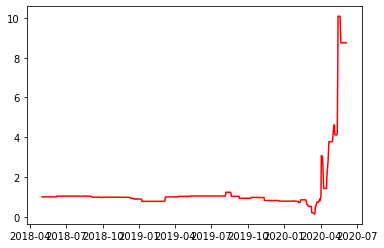

In [23]:
directory = os.fsencode('popularity_export')

def robintrack_strat():    
    asset_data = {}
    standard = merge_rh_vol_w_barset('AMZN')
    returns = pd.DataFrame(1, index=standard.index, columns=['returns','num_assets_traded']) 
    for filename in os.listdir(directory)[:100]:
        security = os.fsdecode(filename).replace('.csv','')
        try:
            asset_returns = normalize_merged(standard,merge_rh_vol_w_barset(security))
            returns['returns'] += asset_returns['profit']
            returns[asset_returns['profit'] != 0]['num_assets_traded'] += 1
            if asset_returns['profit'].sum() > 0: 
                print('{} traded, net: {}, num trades: {}'.format(security,asset_returns['profit'].sum(),len(asset_returns[asset_returns['profit'] > 0])))
        except: 
            print('{} data not found'.format(security))
    returns['returns'] /= returns['num_assets_traded']
    returns['cum_returns'] = returns['returns'].cumprod()
    return returns

res = robintrack_strat()
fig,ax = plt.subplots()
ax.plot(res['cum_returns'],color ='red')
#ax2 = ax.twinx()
#ax2.plot(res['num_assets_traded'])
print(res)
print('cumulative return: {}%, APR: {}%, max_drawdown (approx): {}%'.format(res['cum_returns'].iloc[-1]*10,np.sqrt(res['cum_returns'].iloc[-1])*10,(res['cum_returns'].max() - res['cum_returns'].iloc[-1])*10))
plt.show()


In [15]:
asset_returns = merge_rh_vol_w_barset('EFC')
print(asset_returns[asset_returns['rh_action'] == 1])

             open   high    low  close     volume  users_holding  rh_vol_pct  \
2020-01-23  18.35  18.51  18.33  18.43   782155.0          393.0    0.050246   
2020-04-03   4.05   4.06   3.68   3.90  1185270.0         1197.0    0.100990   

            rh_action    profit  
2020-01-23        1.0  0.010899  
2020-04-03        1.0  1.725926  
